In [1]:
# !conda install -y pandas

In [3]:
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

TensorFlow version: 2.2.0
Eager execution is: True
Keras version: 2.3.0-tf


# Fashion MNIST
<img src="images/fashion_mnist.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" 
     width=850/>

## MNIST Utilities

In [4]:
def plot_mnist_image(image, width, height):
    reshaped = image.reshape(28, 28)
    plt.imshow(reshaped, cmap="binary")
    plt.axis("off")
    
def plot_mnist_images(instances, width=28, height=28,images_per_row=5, **options):
    size = width
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(width,height) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((width, width * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

## Data

In [5]:
image_width = 28
image_height = 28

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

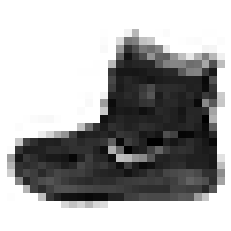

In [7]:
%matplotlib inline
plot_mnist_image(x_train[0], image_width, image_height)
plt.show()

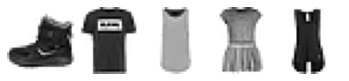

In [8]:
plot_mnist_images(x_train[0:5], image_width, image_height)

# Training

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import backend as K

## Data Normalization

In [10]:
number_of_classes = len(set(y_train))
print("number_of_classes", number_of_classes)

number_of_classes 10


In [11]:
#x_train, x_test = tf.cast(x_train, tf.float32), tf.cast(x_test, tf.float32)
x_train = x_train / 1.0
x_test = x_test / 1.0
x_full = np.concatenate((x_train, x_test), axis=0)
print(x_full.shape)

print(type(x_train))
print(x_train.shape)
print(x_train.dtype)
print(y_train.shape)
print(y_train.dtype)

(70000, 28, 28)
<class 'numpy.ndarray'>
(60000, 28, 28)
float64
(60000,)
uint8


### Normalise

In [12]:
normalization = Normalization()
normalization.adapt(x_full)

## Train
* C: Convolution layer
* P: Pooling layer
* B: Batch normalization layer
* F: Fully connected layer
* O: Output fully connected softmax layer

In [13]:
# Reshape data based on channels first / channels last strategy.
# This is dependent on whether you use TF, Theano or CNTK as backend.
# Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
if K.image_data_format() == 'channels_first':
    x = x_train.reshape(x_train.shape[0], 1, image_width, image_height)
    x_test = x_test.reshape(x_test.shape[0], 1, image_width, image_height)
    input_shape = (1, image_width, image_height)
else:
    x_train = x_train.reshape(x_train.shape[0], image_width, image_height, 1)
    x_test = x_test.reshape(x_test.shape[0], image_width, image_height, 1)
    input_shape = (image_width, image_height, 1)

### Training Utilities

In [38]:
# tensorboard --logdir=/full_path_to_your_logs

import os
log_dir = os.getcwd() + os.path.sep + "logs"
print(log_dir)

/home/oonisim/home/repositories/git/oonisim/tensorflow/keras_experiments/fashion_mnist/logs


In [46]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    write_graph=True,
    write_images=True,
    histogram_freq=1,  # How often to log histogram visualizations
    embeddings_freq=1,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

In [47]:
batch_size = 500
number_of_epochs = 10
validation_split = 0.2
verbosity = 1
use_multiprocessing = True
workers = 4

def train(model, x, y):
    model.compile(
        optimizer='adam', 
        loss=tf.keras.losses.sparse_categorical_crossentropy, 
        metrics=['accuracy']
    )
    history = model.fit(
        x, 
        y,
        shuffle=True,
        batch_size=batch_size,
        epochs=number_of_epochs,
        validation_split=validation_split,
        use_multiprocessing=use_multiprocessing,
        workers=workers,
        verbose=verbosity,
        callbacks=[
            tensorboard_callback
        ]
    )
    return(history)

### Train CPBFO model  (F/ReLU/He)

In [49]:
model = Sequential([
    normalization,
    Conv2D(
        name="conv01",
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(
        name="pool01",
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(
        name="batch_before_full01"
    ),
    Dense(
        name="full01", 
        units=300, 
        activation="relu"
    ),     # Fully connected layer 
    Dense(
        name="output_softmax", 
        units=number_of_classes, 
        activation="softmax"
    )
])

history = train(model, x_train, y_train)
print(history)
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

Epoch 1/10
96/96 [==============================] - 66s 686ms/step - loss: 0.4840 - accuracy: 0.8505 - val_loss: 1.0060 - val_accuracy: 0.6546
Epoch 2/10
96/96 [==============================] - 68s 708ms/step - loss: 0.2416 - accuracy: 0.9136 - val_loss: 0.2971 - val_accuracy: 0.8957
Epoch 3/10
96/96 [==============================] - 71s 736ms/step - loss: 0.1846 - accuracy: 0.9326 - val_loss: 0.2752 - val_accuracy: 0.9046
Epoch 4/10
96/96 [==============================] - 85s 886ms/step - loss: 0.1390 - accuracy: 0.9495 - val_loss: 0.3535 - val_accuracy: 0.8853
Epoch 5/10
96/96 [==============================] - 64s 669ms/step - loss: 0.1105 - accuracy: 0.9587 - val_loss: 0.3259 - val_accuracy: 0.9007
Epoch 6/10
96/96 [==============================] - 74s 767ms/step - loss: 0.0873 - accuracy: 0.9681 - val_loss: 0.4010 - val_accuracy: 0.8878
Epoch 7/10
96/96 [==============================] - 67s 702ms/step - loss: 0.0743 - accuracy: 0.9742 - val_loss: 0.4386 - val_accuracy: 0.8701

### Train CPBCPBFO model (F/ReLU/He)

In [2]:
model = Sequential([
    normalization,
    Conv2D(
        name="conv_01",
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(300, activation="relu"),                    # Fully connected layer 
    Dense(number_of_classes, activation="softmax")
])
model.layers

train(model, x_train, y_train)

NameError: name 'Sequential' is not defined

### Train CPBCPBFBFO model (F/ReLU/He)

In [16]:
model = Sequential([
    normalization,
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(300, activation="relu"),                    # Fully connected layer 
    BatchNormalization(),
    Dense(200, activation="relu"),                    # Fully connected layer 
    Dense(number_of_classes, activation="softmax")    # Output layer
])

train(model, x_train, y_train)

Epoch 1/10
96/96 [==============================] - 84s 875ms/step - loss: 0.3845 - accuracy: 0.8624 - val_loss: 1.5212 - val_accuracy: 0.4525
Epoch 2/10
96/96 [==============================] - 81s 847ms/step - loss: 0.2319 - accuracy: 0.9156 - val_loss: 1.8814 - val_accuracy: 0.4304
Epoch 3/10
96/96 [==============================] - 78s 818ms/step - loss: 0.1837 - accuracy: 0.9337 - val_loss: 1.5232 - val_accuracy: 0.5142
Epoch 4/10
96/96 [==============================] - 111s 1s/step - loss: 0.1499 - accuracy: 0.9449 - val_loss: 0.6288 - val_accuracy: 0.7786
Epoch 5/10
96/96 [==============================] - 103s 1s/step - loss: 0.1193 - accuracy: 0.9571 - val_loss: 0.3661 - val_accuracy: 0.8723
Epoch 6/10
96/96 [==============================] - 92s 961ms/step - loss: 0.0976 - accuracy: 0.9652 - val_loss: 0.2755 - val_accuracy: 0.9093
Epoch 7/10
96/96 [==============================] - 91s 952ms/step - loss: 0.0745 - accuracy: 0.9738 - val_loss: 0.2719 - val_accuracy: 0.9139
Epo

### Train CPBFO model  (F/SELU/LeCun)
SELU activation + LeCun initialization at Fully connected layer

In [17]:
model = Sequential([
    normalization,
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        kernel_initializer='he_normal', 
        activation='relu',
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(
        300, 
        kernel_initializer='lecun_normal', 
        activation='selu'
    ),                    # Fully connected layer 
    Dense(
        number_of_classes, 
        activation="softmax"
    )
])

train(model, x_train, y_train)

Epoch 1/10
96/96 [==============================] - 45s 466ms/step - loss: 0.8387 - accuracy: 0.8342 - val_loss: 0.5070 - val_accuracy: 0.8423
Epoch 2/10
96/96 [==============================] - 49s 508ms/step - loss: 0.3488 - accuracy: 0.8938 - val_loss: 0.3518 - val_accuracy: 0.8882
Epoch 3/10
96/96 [==============================] - 50s 517ms/step - loss: 0.2436 - accuracy: 0.9178 - val_loss: 0.3776 - val_accuracy: 0.8878
Epoch 4/10
96/96 [==============================] - 51s 531ms/step - loss: 0.2032 - accuracy: 0.9315 - val_loss: 0.3527 - val_accuracy: 0.8964
Epoch 5/10
96/96 [==============================] - 47s 486ms/step - loss: 0.1627 - accuracy: 0.9418 - val_loss: 0.4321 - val_accuracy: 0.8763
Epoch 6/10
96/96 [==============================] - 50s 516ms/step - loss: 0.1398 - accuracy: 0.9513 - val_loss: 0.3455 - val_accuracy: 0.8972
Epoch 7/10
96/96 [==============================] - 51s 529ms/step - loss: 0.1199 - accuracy: 0.9580 - val_loss: 0.3290 - val_accuracy: 0.9094

### Train CPBCPBFO model (F/SELU/LeCun)
SELU activation + LeCun initialization at Fully connected layer

In [20]:
model = Sequential([
    normalization,
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        kernel_initializer='he_normal', 
        activation='relu',
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        kernel_initializer='he_normal', 
        activation='relu',
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(
        300, 
        kernel_initializer='lecun_normal', 
        activation='selu'
    ),                    # Fully connected layer 
    Dense(
        number_of_classes, 
        activation="softmax"
    )
])

train(model, x_train, y_train)

Epoch 1/10
96/96 [==============================] - 62s 646ms/step - loss: 0.5619 - accuracy: 0.8444 - val_loss: 0.5056 - val_accuracy: 0.8047
Epoch 2/10
96/96 [==============================] - 63s 658ms/step - loss: 0.2713 - accuracy: 0.9033 - val_loss: 0.3426 - val_accuracy: 0.8764
Epoch 3/10
96/96 [==============================] - 66s 687ms/step - loss: 0.2097 - accuracy: 0.9235 - val_loss: 0.2929 - val_accuracy: 0.8967
Epoch 4/10
96/96 [==============================] - 70s 726ms/step - loss: 0.1751 - accuracy: 0.9355 - val_loss: 0.2956 - val_accuracy: 0.8977
Epoch 5/10
96/96 [==============================] - 59s 619ms/step - loss: 0.1481 - accuracy: 0.9453 - val_loss: 0.3122 - val_accuracy: 0.8959
Epoch 6/10
96/96 [==============================] - 58s 608ms/step - loss: 0.1204 - accuracy: 0.9559 - val_loss: 0.3157 - val_accuracy: 0.8926
Epoch 7/10
96/96 [==============================] - 67s 700ms/step - loss: 0.1137 - accuracy: 0.9579 - val_loss: 0.4035 - val_accuracy: 0.8763

### Train CPBCPBFFO model  (F/SELU/LeCun)
SELU activation + LeCun initialization at Fully connected layer

In [19]:
model = Sequential([
    normalization,
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        kernel_initializer='he_normal', # Using SELU+LeCun damages the validation
        activation='relu',
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        kernel_initializer='he_normal', 
        activation='relu',
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(
        300, 
        kernel_initializer='lecun_normal', 
        activation='selu'
    ),                    # Fully connected layer 
    Dense(
        200, 
        kernel_initializer='lecun_normal', 
        activation='selu'
    ),                    # Fully connected layer 
    Dense(
        number_of_classes, 
        activation="softmax"
    )
])

train(model, x_train, y_train)

Epoch 1/10
96/96 [==============================] - 76s 793ms/step - loss: 0.5246 - accuracy: 0.8407 - val_loss: 0.4289 - val_accuracy: 0.8363
Epoch 2/10
96/96 [==============================] - 69s 714ms/step - loss: 0.2527 - accuracy: 0.9080 - val_loss: 0.3291 - val_accuracy: 0.8820
Epoch 3/10
96/96 [==============================] - 67s 702ms/step - loss: 0.2023 - accuracy: 0.9254 - val_loss: 0.2985 - val_accuracy: 0.8928
Epoch 4/10
96/96 [==============================] - 66s 688ms/step - loss: 0.1678 - accuracy: 0.9379 - val_loss: 0.3784 - val_accuracy: 0.8767
Epoch 5/10
96/96 [==============================] - 66s 690ms/step - loss: 0.1402 - accuracy: 0.9481 - val_loss: 0.3387 - val_accuracy: 0.8828
Epoch 6/10
96/96 [==============================] - 78s 811ms/step - loss: 0.1131 - accuracy: 0.9579 - val_loss: 0.3471 - val_accuracy: 0.8901
Epoch 7/10
96/96 [==============================] - 77s 806ms/step - loss: 0.0977 - accuracy: 0.9647 - val_loss: 0.4070 - val_accuracy: 0.8761